In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


#from selenium.webdriver.edge.options import Options

#edge_options = Options()
#edge_options.add_argument('--headless')
#edge_options.add_argument("--disable-images")  # Disable images
#edge_options.add_argument("--disable-javascript")  # Disable JavaScript
#edge_options.add_argument("--disable-plugins")  # Disable plugins
#edge_options.add_argument("--disable-extensions")  # Disable extensions
#edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
#edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

#driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


#driver.maximize_window()

#driver.execute_script("document.body.style.zoom='67%'")

In [ ]:
driver.get('https://millercenter.org/the-presidency/presidential-speeches')

In [ ]:
for e in driver.find_elements(By.CSS_SELECTOR, 'div[class*="js-form-item form-item js-form-type-checkbox form-item-field-president"]'):
    driver.execute_script('arguments[0].click();', e)
    time.sleep(3)

In [ ]:
count_same=0
count_prev=0

while True:
    #driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", e)
    driver.execute_script("window.scrollTo({ top: document.body.scrollHeight, behavior: 'smooth' });")

    time.sleep(3)

    speeches=driver.find_elements(By.CSS_SELECTOR, 'div[class="views-infinite-scroll-content-wrapper clearfix"] div[class="views-row"]')

    count_same+=1 if len(speeches)==count_prev else 0
    if count_same==5:
        break

    count_prev=len(speeches)



    print(f'{count_prev}, {count_same}',end='\r')


In [ ]:
speeches=driver.find_elements(By.CSS_SELECTOR, 'div[class="views-infinite-scroll-content-wrapper clearfix"] div[class="views-row"] span[class="x"] a')
speech_urls=[e.get_attribute('href') for e in speeches]

In [ ]:
#pickle.dump(speech_urls, open('speech_urls.pickle', 'wb'))
speech_urls=pickle.load( open('speech_urls.pickle', 'rb'))

In [ ]:
all_data=[]

for i, speech_url in enumerate(speech_urls,start=1):
    try:
        html=requests.get(speech_url, headers=headers).content
        soup=BeautifulSoup(html, 'html.parser')
    except:
        print(f'error with {speech_url}')
        continue

    try:
        script='\n'.join([e.text.replace('\xa0','').replace('\n\n','\n').strip() for e in soup.select('div[class="x"] x, div[class="x"] x')])
    except:
        script=None

    try:
        president=soup.select_one('div[class="about-this-episode"] p[class="x"]').text.strip()
    except:
        president=None

    try:
        speech_date=soup.select_one('div[class="about-this-episode"] p[class="x"]').text.strip()
    except:
        speech_date=None

    try:
        speech_location=soup.select_one('div[class="about-this-episode"] span[class="x"]').text.strip()
    except:
        speech_location=None

    
    data_dict={'URL':speech_url, 'President':president, 'Speech Date':speech_date, 'Speech Location':speech_location, 'Script':script}
    all_data.append(data_dict)

    print(f'{i}/{len(speech_urls)}',end='\r')
    #break

pickle.dump(all_data, open('usa_presidential_speeches.pickle', 'wb'))


In [ ]:
all_data=pickle.load( open('usa_presidential_speeches.pickle', 'rb'))


In [ ]:
df=pd.DataFrame(all_data)

In [2]:
#df.to_csv('usa_presidential_speeches.csv',index=False)
df=pd.read_csv('usa_presidential_speeches.csv')

In [3]:
df['Speech Date']=pd.to_datetime(df['Speech Date'])

In [4]:
df

,URL,President,Speech Date,Speech Location,Script
0,https://millercenter.org/the-presidency/presid...,Donald Trump,2025-06-21,The White House,"Thank you very much.\nA short time ago, the U...."
1,https://millercenter.org/the-presidency/presid...,Donald Trump,2025-03-04,The White House,"THE PRESIDENT: Speaker Johnson, Vice President..."
2,https://millercenter.org/the-presidency/presid...,Donald Trump,2025-01-20,The White House,"THE PRESIDENT: Thank you. Thank you very much,..."
3,https://millercenter.org/the-presidency/presid...,Joe Biden,2025-01-15,The White House,"THE PRESIDENT: My fellow Americans, I am speak..."
4,https://millercenter.org/the-presidency/presid...,Joe Biden,2024-09-24,The White House,"THE PRESIDENT: My fellow leaders, today is the..."
...,...,...,...,...,...
1047,https://millercenter.org/the-presidency/presid...,George Washington,1790-12-29,Miller Center,"I the President of the United States, by my ow..."
1048,https://millercenter.org/the-presidency/presid...,George Washington,1790-12-08,Miller Center,Fellow citizens of the Senate and House of Rep...
1049,https://millercenter.org/the-presidency/presid...,George Washington,1790-01-08,Miller Center,Fellow Citizens of the Senate and House of Rep...
1050,https://millercenter.org/the-presidency/presid...,George Washington,1789-10-03,Miller Center,Whereas it is the duty of all Nations to ackno...


In [5]:
df['President'].value_counts()

President
Lyndon B. Johnson        71
Ronald Reagan            60
Barack Obama             51
Franklin D. Roosevelt    49
Donald Trump             46
John F. Kennedy          44
George W. Bush           39
Bill Clinton             39
Woodrow Wilson           33
Grover Cleveland         32
Ulysses S. Grant         32
Andrew Johnson           31
Herbert Hoover           30
Joe Biden                28
Andrew Jackson           26
James K. Polk            25
Thomas Jefferson         24
George H. W. Bush        23
Richard M. Nixon         23
Jimmy Carter             22
James Madison            22
Theodore Roosevelt       22
George Washington        21
Harry S. Truman          19
Warren G. Harding        18
John Tyler               18
Benjamin Harrison        16
Rutherford B. Hayes      16
Dwight D. Eisenhower     15
Franklin Pierce          15
Abraham Lincoln          15
Gerald Ford              14
James Buchanan           14
William McKinley         14
William Taft             12
Calvin Coo

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

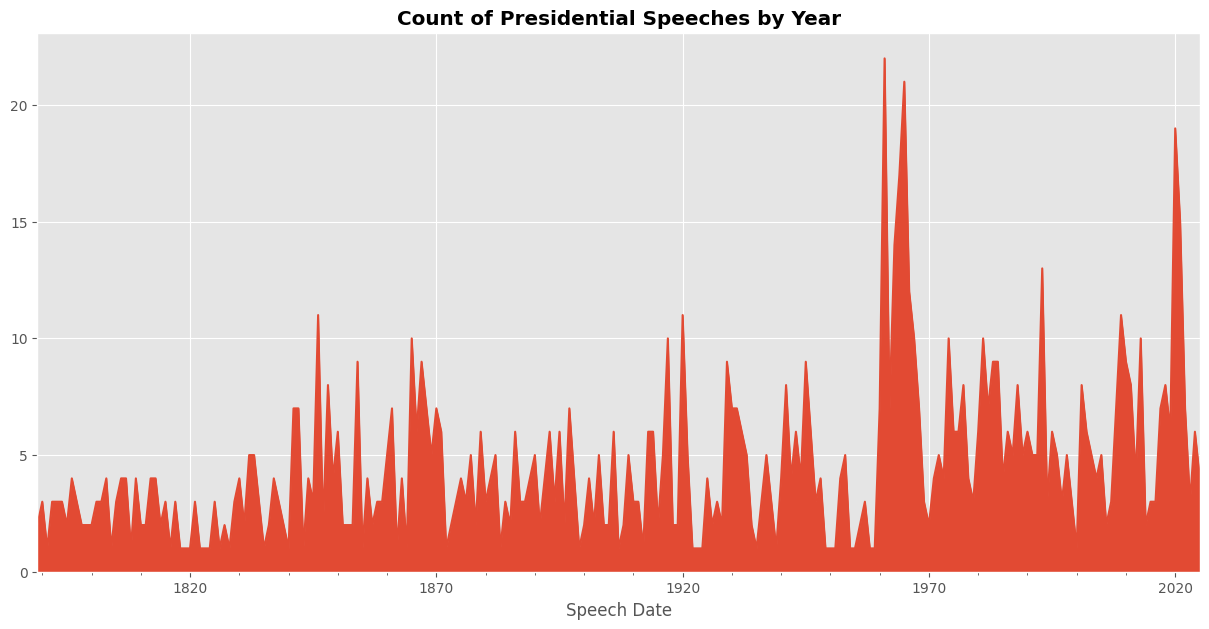

In [7]:
grouped=df.groupby(df['Speech Date'].dt.to_period('Y'))['Script'].count()

plt.figure(figsize=(15,7))
grouped.plot.area()#(marker='.')
plt.title('Count of Presidential Speeches by Year',fontweight='bold')
plt.show()


In [8]:
import pycountry

countries = {}
for country in pycountry.countries:
    name = country.name
    alt_names = {name}
    if hasattr(country, 'official_name'):
        alt_names.add(country.official_name)

    countries[name] = list(alt_names)


In [9]:
countries['Georgia']

['Georgia']

In [10]:
import inflect
from countryinfo import CountryInfo

p = inflect.engine()

for i, (key, value_list) in enumerate(countries.items()):
    try:
        country = CountryInfo(key)
        demonym = country.info().get('demonym')
        if demonym:
            countries[key].append(demonym)
            plural_demonym = p.plural(demonym)
            countries[key].append(plural_demonym)
    except:
        continue

countries['Georgia']

['Georgia', 'Georgian', 'Georgians']

In [11]:
countries

{'Aruba': ['Aruba', 'Aruban', 'Arubans'],
 'Afghanistan': ['Afghanistan',
  'Islamic Republic of Afghanistan',
  'Afghan',
  'Afghans'],
 'Angola': ['Republic of Angola', 'Angola', 'Angolan', 'Angolans'],
 'Anguilla': ['Anguilla', 'Anguillian', 'Anguillians'],
 'Åland Islands': ['Åland Islands'],
 'Albania': ['Albania', 'Republic of Albania', 'Albanian', 'Albanians'],
 'Andorra': ['Andorra', 'Principality of Andorra'],
 'United Arab Emirates': ['United Arab Emirates', 'Emirati', 'Emiratis'],
 'Argentina': ['Argentine Republic',
  'Argentina',
  'Argentinean',
  'Argentineans'],
 'Armenia': ['Republic of Armenia', 'Armenia', 'Armenian', 'Armenians'],
 'American Samoa': ['American Samoa', 'American Samoan', 'American Samoans'],
 'Antarctica': ['Antarctica'],
 'French Southern Territories': ['French Southern Territories'],
 'Antigua and Barbuda': ['Antigua and Barbuda',
  'Antiguan,Barbudan',
  'Antiguan,Barbudans'],
 'Australia': ['Australia', 'Australian', 'Australians'],
 'Austria': ['

In [12]:
countries['Iran, Islamic Republic of'].extend(['Iranian', 'Iranians'])
countries['Iran, Islamic Republic of']

['Islamic Republic of Iran',
 'Iran, Islamic Republic of',
 'Iranian',
 'Iranians']

In [13]:
all_data=[]

for i, (president, script) in enumerate(zip(df['President'], df['Script'])):
    try:
        tokens=script.split()
    except:
        tokens=[]

    for country, value_list in countries.items():
        country_count=0
        for value in value_list:
            if value in tokens:
                country_count+=1

        data_dict={'President':president, 'Script':script, 'Country':country, 'Count':country_count}
        all_data.append(data_dict)

    print(f'{i}/{len(df['Script'])}',end='\r')    
    

In [25]:
data=pd.DataFrame(all_data)
data=data.iloc[::-1].reset_index(drop=True)
president_order = data['President'].drop_duplicates()


C:\Users\berid\AppData\Local\Temp\ipykernel_5376\2299621956.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = grouped.pivot_table(index='Country', columns='President', values='Count', aggfunc='sum', sort=False).astype(int)


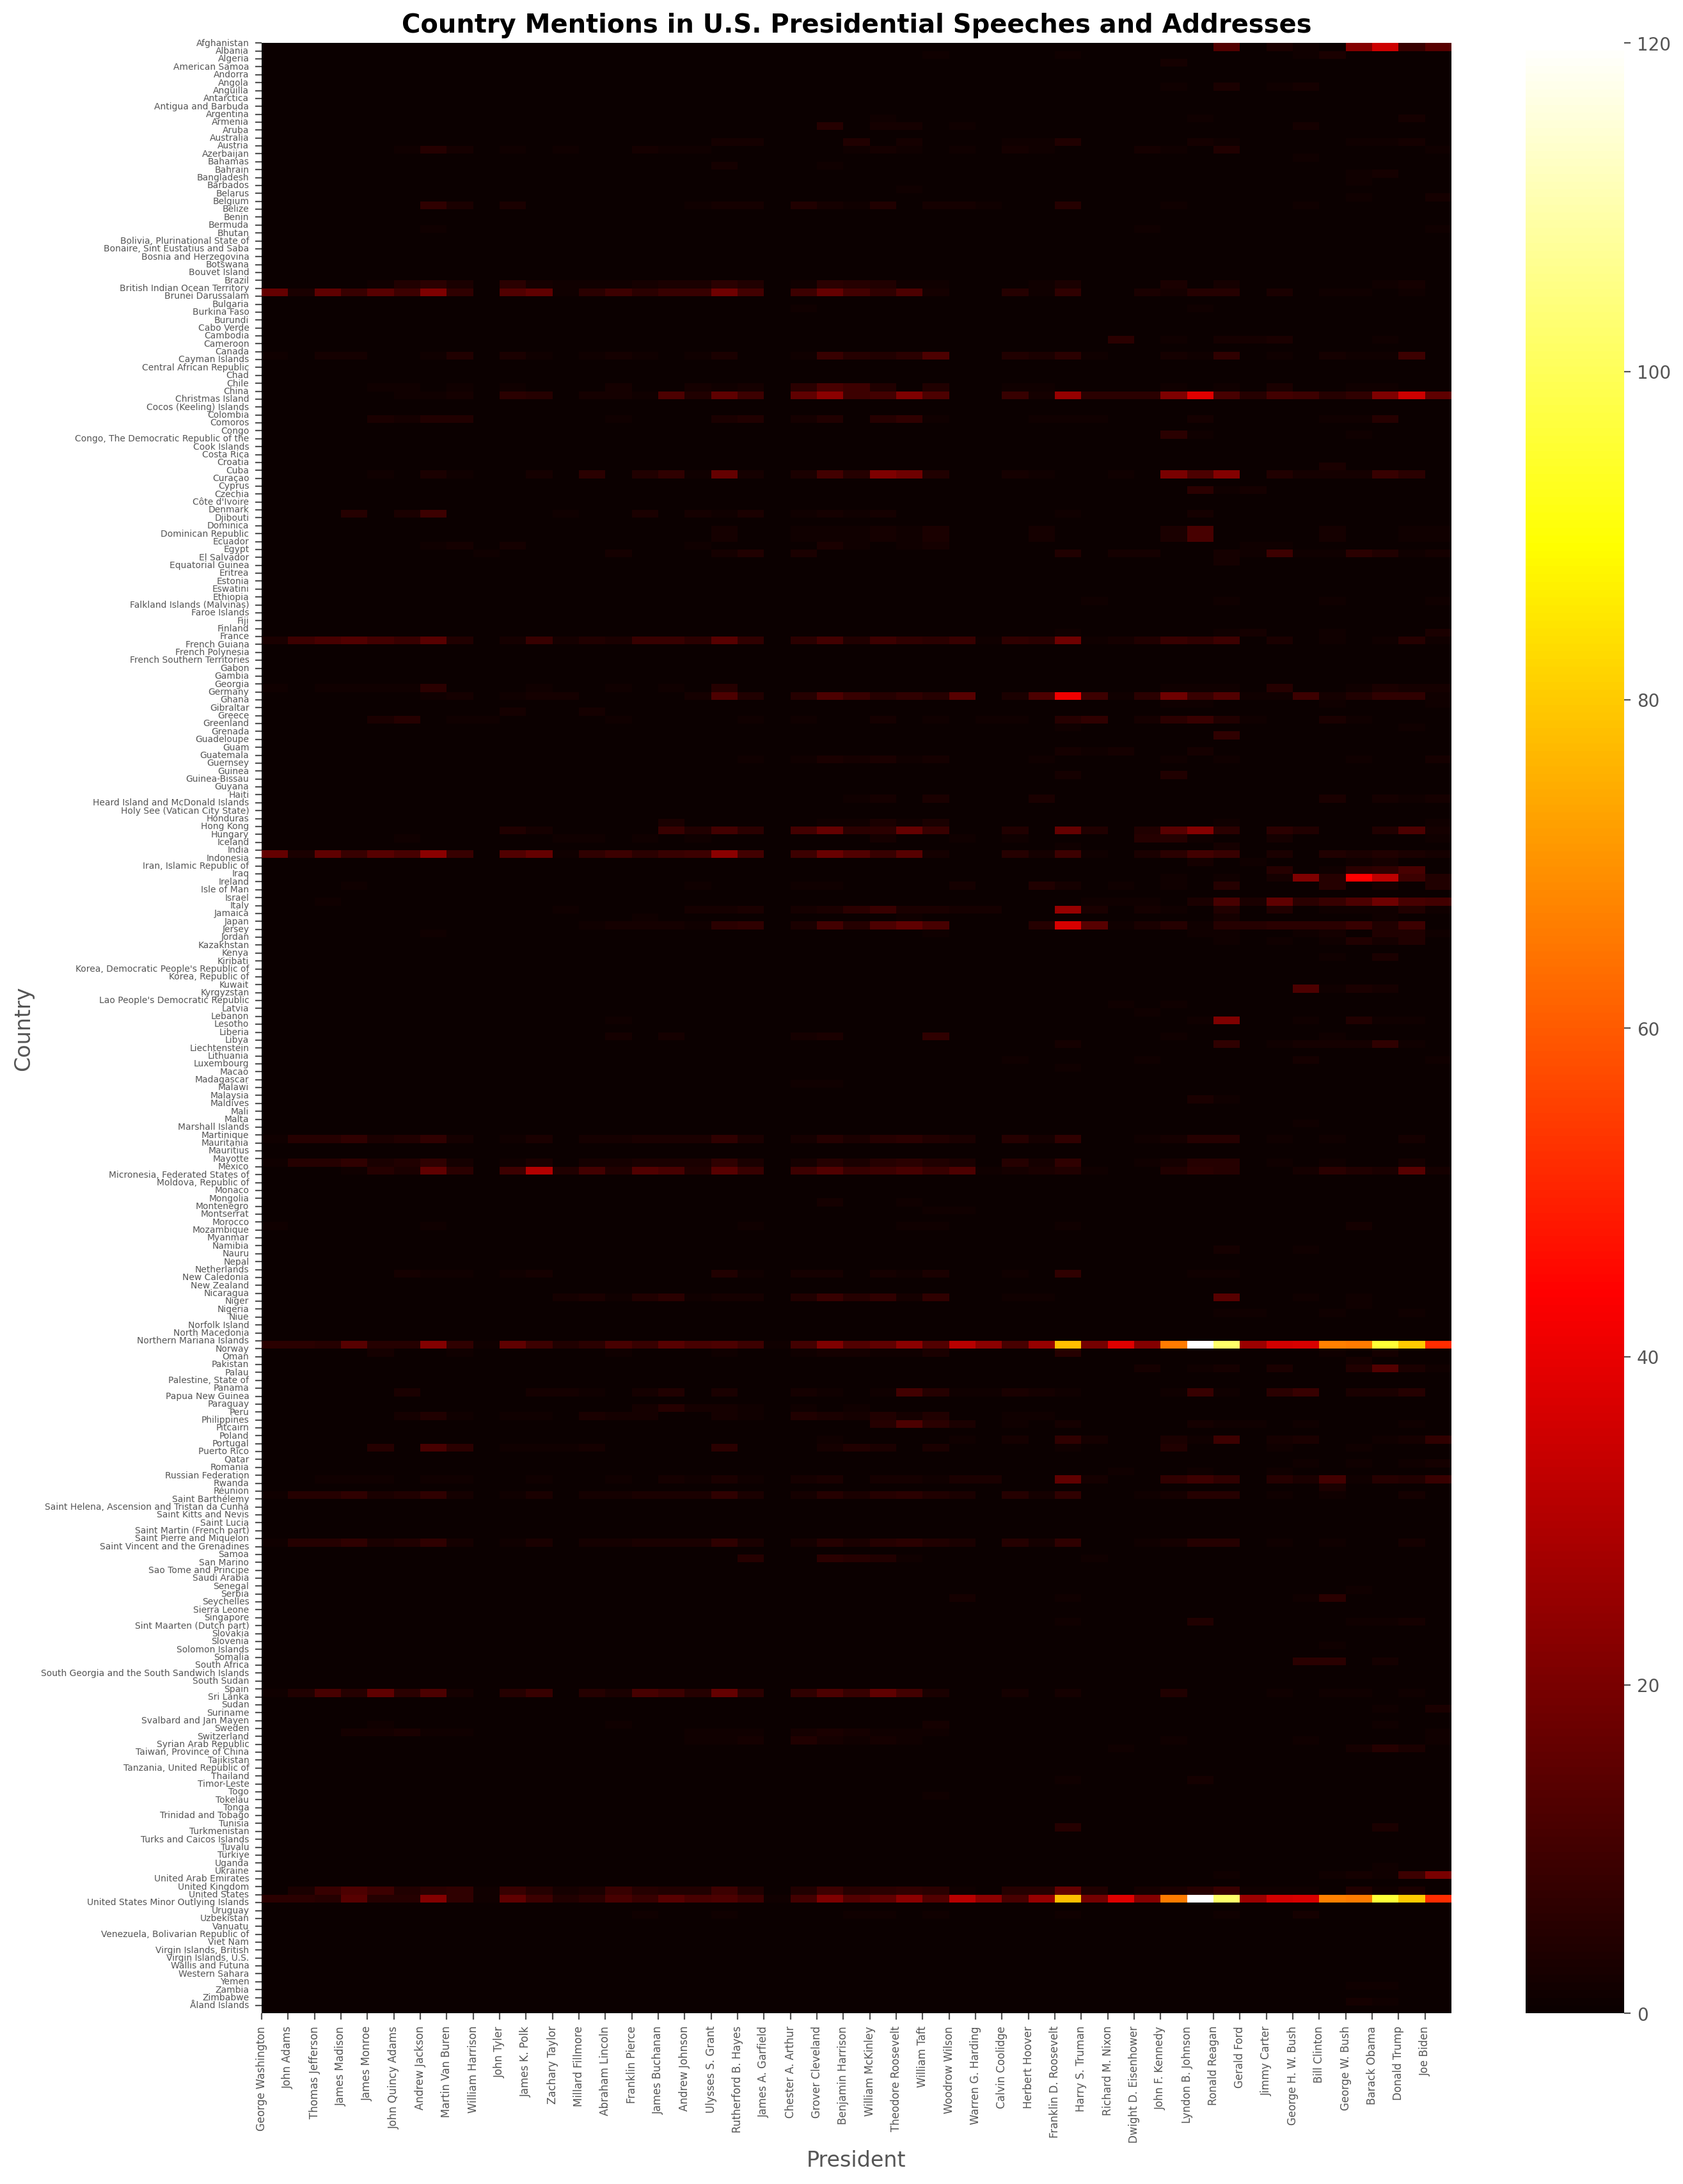

In [29]:
grouped=data.groupby(['President', 'Country'])['Count'].sum().reset_index()
grouped['President'] = pd.Categorical(grouped['President'], categories=president_order, ordered=True)
pivoted = grouped.pivot_table(index='Country', columns='President', values='Count', aggfunc='sum', sort=False).astype(int)

plt.figure(figsize=(15, 20),dpi=200)
sns.heatmap(pivoted, annot=False, cmap='hot')
plt.yticks(ticks=range(len(pivoted.index)), labels=list(pivoted.index), size=5)
plt.xticks(ticks=range(len(pivoted.columns)), labels=list(pivoted.columns), size=6)
plt.title('Country Mentions in U.S. Presidential Speeches and Addresses', fontweight='bold')


plt.show()